In [2]:
from google.cloud import bigquery

client = bigquery.Client(project='datamanagementbi')
tabla_completa = 'datamanagementbi.gold_data.modelo_final'
tabla = client.get_table(tabla_completa)

query = """
    SELECT *
    FROM `datamanagementbi.gold_data.modelo_final`
"""

df = client.query(query).to_dataframe()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# MODELO DE PREDICCIÓN DE DEMANDA ENERGÉTICA
# ============================================================================

print("⚡ MODELO DE PREDICCIÓN DE DEMANDA ENERGÉTICA")
print("=" * 80)

# Mapeo de sectores
sector_map = {1: 'Industrial', 2: 'Residencial', 3: 'Servicios'}
df['Sector_nombre'] = df['id_sector_economico'].map(sector_map)

⚡ MODELO DE PREDICCIÓN DE DEMANDA ENERGÉTICA



🌡️ PARTE 1: ANÁLISIS PROFUNDO TEMPERATURA-CONSUMO

🏭 INDUSTRIAL

📊 Correlaciones:
   • Temperatura simple: 0.0305
   • Distancia a confort (20°C): 0.0021

🌡️ Correlación por estación:
   • Invierno     → -0.0080
   • Primavera    → +0.0131
   • Verano       → +0.0264
   • Otoño        → +0.0225

📈 Rango de temperatura: 1.5°C - 35.4°C

📊 Consumo por rango de temperatura:
   • Frío (<12.5°C):    4,807,852 kW
   • Medio (12.5-23.0°C): 4,878,927 kW
   • Calor (>23.0°C):   5,778,978 kW

🏠 RESIDENCIAL

📊 Correlaciones:
   • Temperatura simple: -0.0527
   • Distancia a confort (20°C): 0.2262

🌡️ Correlación por estación:
   • Invierno     → -0.0355
   • Primavera    → -0.0640
   • Verano       → +0.2656
   • Otoño        → +0.0652

📈 Rango de temperatura: 1.5°C - 35.4°C

📊 Consumo por rango de temperatura:
   • Frío (<12.5°C):    47,011,735 kW
   • Medio (12.5-23.0°C): 38,995,414 kW
   • Calor (>23.0°C):   44,419,181 kW

🏢 SERVICIOS

📊 Correlaciones:
   • Temperatura simple: 0.2653
   • Dist

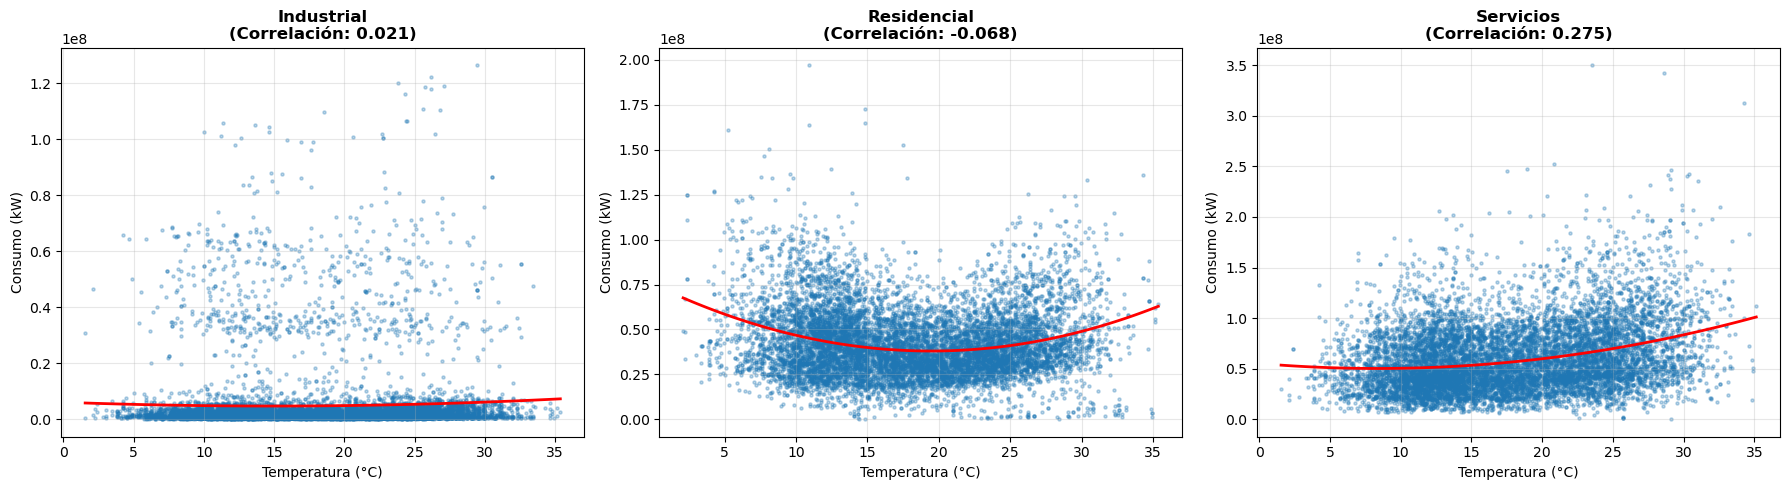

In [6]:
# ============================================================================
# PARTE 1: ANÁLISIS DE CORRELACIÓN CON TEMPERATURA POR SECTOR
# ============================================================================

print("\n🌡️ PARTE 1: ANÁLISIS PROFUNDO TEMPERATURA-CONSUMO")
print("=" * 80)

for sector in ['Industrial', 'Residencial', 'Servicios']:
    print(f"\n{'='*70}")
    print(f"{'🏭' if sector == 'Industrial' else '🏠' if sector == 'Residencial' else '🏢'} {sector.upper()}")
    print(f"{'='*70}")
    
    df_sector = df[df['Sector_nombre'] == sector].copy()
    
    # Eliminar nulos
    df_temp = df_sector[['temperatura_media_ciudad', 'consumo_kwh', 'mes']].dropna()
    
    if len(df_temp) > 0:
        # Correlación simple
        corr_simple = df_temp['temperatura_media_ciudad'].corr(df_temp['consumo_kwh'])
        
        # Crear variable de distancia a temperatura de confort
        TEMP_CONFORT = 20
        df_temp['dist_confort'] = abs(df_temp['temperatura_media_ciudad'] - TEMP_CONFORT)
        corr_distancia = df_temp['dist_confort'].corr(df_temp['consumo_kwh'])
        
        # Separar por estación
        df_temp['estacion'] = df_temp['mes'].map({
            12: 'Invierno', 1: 'Invierno', 2: 'Invierno',
            3: 'Primavera', 4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano',
            9: 'Otoño', 10: 'Otoño', 11: 'Otoño'
        })
        
        print(f"\n📊 Correlaciones:")
        print(f"   • Temperatura simple: {corr_simple:.4f}")
        print(f"   • Distancia a confort (20°C): {corr_distancia:.4f}")
        
        print(f"\n🌡️ Correlación por estación:")
        for estacion in ['Invierno', 'Primavera', 'Verano', 'Otoño']:
            df_est = df_temp[df_temp['estacion'] == estacion]
            if len(df_est) > 10:
                corr_est = df_est['temperatura_media_ciudad'].corr(df_est['consumo_kwh'])
                print(f"   • {estacion:12} → {corr_est:+.4f}")
        
        # Rango de temperaturas
        temp_min, temp_max = df_temp['temperatura_media_ciudad'].min(), df_temp['temperatura_media_ciudad'].max()
        print(f"\n📈 Rango de temperatura: {temp_min:.1f}°C - {temp_max:.1f}°C")
        
        # Consumo en extremos de temperatura
        q25 = df_temp['temperatura_media_ciudad'].quantile(0.25)
        q75 = df_temp['temperatura_media_ciudad'].quantile(0.75)
        
        consumo_frio = df_temp[df_temp['temperatura_media_ciudad'] <= q25]['consumo_kwh'].mean()
        consumo_medio = df_temp[(df_temp['temperatura_media_ciudad'] > q25) & 
                                (df_temp['temperatura_media_ciudad'] < q75)]['consumo_kwh'].mean()
        consumo_calor = df_temp[df_temp['temperatura_media_ciudad'] >= q75]['consumo_kwh'].mean()
        
        print(f"\n📊 Consumo por rango de temperatura:")
        print(f"   • Frío (<{q25:.1f}°C):    {consumo_frio:,.0f} kW")
        print(f"   • Medio ({q25:.1f}-{q75:.1f}°C): {consumo_medio:,.0f} kW")
        print(f"   • Calor (>{q75:.1f}°C):   {consumo_calor:,.0f} kW")

# Visualización de temperatura vs consumo por sector
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, sector in enumerate(['Industrial', 'Residencial', 'Servicios']):
    ax = axes[idx]
    df_sector = df[df['Sector_nombre'] == sector]
    df_plot = df_sector[['temperatura_media_ciudad', 'consumo_kwh']].dropna()
    
    if len(df_plot) > 0:
        # Sample para que no sea muy pesado
        if len(df_plot) > 10000:
            df_plot = df_plot.sample(10000, random_state=42)
        
        ax.scatter(df_plot['temperatura_media_ciudad'], df_plot['consumo_kwh'], 
                  alpha=0.3, s=5)
        
        # Línea de tendencia
        z = np.polyfit(df_plot['temperatura_media_ciudad'], df_plot['consumo_kwh'], 2)
        p = np.poly1d(z)
        temp_range = np.linspace(df_plot['temperatura_media_ciudad'].min(), 
                                df_plot['temperatura_media_ciudad'].max(), 100)
        ax.plot(temp_range, p(temp_range), "r-", linewidth=2)
        
        corr = df_plot['temperatura_media_ciudad'].corr(df_plot['consumo_kwh'])
        ax.set_title(f'{sector}\n(Correlación: {corr:.3f})', fontweight='bold')
        ax.set_xlabel('Temperatura (°C)')
        ax.set_ylabel('Consumo (kW)')
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# ============================================================================
# PARTE 2: CONSTRUCCIÓN DE MODELOS PREDICTIVOS
# ============================================================================

print("\n" + "=" * 80)
print("🤖 PARTE 2: MODELOS PREDICTIVOS POR SECTOR")
print("=" * 80)

resultados_modelos = {}

for sector in ['Industrial', 'Residencial', 'Servicios']:
    print(f"\n{'='*70}")
    print(f"ENTRENANDO MODELO: {sector.upper()}")
    print(f"{'='*70}")
    
    # Preparar datos
    df_sector = df[df['Sector_nombre'] == sector].copy()
    
    # Seleccionar features
    features = []
    for col in ['id_geografia', 'id_tramo_horario', 'temperatura_media_ciudad', 
                'humedad_media_ciudad', 'mes', 'dia_del_mes', 'es_fin_de_semana', 
                'es_festivo', 'poblacion']:
        if col in df_sector.columns:
            features.append(col)
    
    # Eliminar nulos
    df_modelo = df_sector[features + ['consumo_kwh']].dropna()
    
    # Convertir booleanos
    for col in df_modelo.columns:
        if df_modelo[col].dtype == 'bool':
            df_modelo[col] = df_modelo[col].astype(int)
    
    print(f"\n📊 Tamaño del dataset: {len(df_modelo):,} registros")
    print(f"📊 Features utilizadas: {len(features)}")
    
    # Features adicionales (ingeniería de features)
    df_modelo['temp_cuadrado'] = df_modelo['temperatura_media_ciudad'] ** 2
    df_modelo['dist_confort'] = abs(df_modelo['temperatura_media_ciudad'] - 20)
    df_modelo['temp_x_humedad'] = df_modelo['temperatura_media_ciudad'] * df_modelo['humedad_media_ciudad']
    
    features_completas = features + ['temp_cuadrado', 'dist_confort', 'temp_x_humedad']
    
    X = df_modelo[features_completas]
    y = df_modelo['consumo_kwh']
    
    # Split train/test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"   • Train: {len(X_train):,} | Test: {len(X_test):,}")
    
    # ===== MODELO 1: Random Forest =====
    print(f"\n🌲 Modelo 1: Random Forest")
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=50,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    
    # Métricas
    r2_rf = r2_score(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
    
    print(f"   • R²:   {r2_rf:.4f}")
    print(f"   • MAE:  {mae_rf:,.0f} kW")
    print(f"   • RMSE: {rmse_rf:,.0f} kW")
    print(f"   • MAPE: {mape_rf:.2f}%")
    
    # ===== MODELO 2: Gradient Boosting =====
    print(f"\n📈 Modelo 2: Gradient Boosting")
    gb_model = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        random_state=42
    )
    
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    
    # Métricas
    r2_gb = r2_score(y_test, y_pred_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
    mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100
    
    print(f"   • R²:   {r2_gb:.4f}")
    print(f"   • MAE:  {mae_gb:,.0f} kW")
    print(f"   • RMSE: {rmse_gb:,.0f} kW")
    print(f"   • MAPE: {mape_gb:.2f}%")
    
    # Seleccionar mejor modelo
    mejor_modelo = rf_model if r2_rf > r2_gb else gb_model
    mejor_nombre = "Random Forest" if r2_rf > r2_gb else "Gradient Boosting"
    mejor_r2 = max(r2_rf, r2_gb)
    mejor_mae = min(mae_rf, mae_gb)
    
    print(f"\n✅ Mejor modelo: {mejor_nombre} (R² = {mejor_r2:.4f})")
    
    # Importancia de features
    importancias = pd.DataFrame({
        'Feature': features_completas,
        'Importancia': mejor_modelo.feature_importances_
    }).sort_values('Importancia', ascending=False)
    
    print(f"\n🎯 Top 10 features más importantes:")
    print(importancias.head(10).to_string(index=False))
    
    # Guardar resultados
    resultados_modelos[sector] = {
        'modelo': mejor_modelo,
        'nombre': mejor_nombre,
        'r2': mejor_r2,
        'mae': mejor_mae,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred_rf if r2_rf > r2_gb else y_pred_gb,
        'importancias': importancias
    }


🤖 PARTE 2: MODELOS PREDICTIVOS POR SECTOR

ENTRENANDO MODELO: INDUSTRIAL

📊 Tamaño del dataset: 216,199 registros
📊 Features utilizadas: 9
   • Train: 172,959 | Test: 43,240

🌲 Modelo 1: Random Forest
   • R²:   0.9829
   • MAE:  522,487 kW
   • RMSE: 2,075,723 kW
   • MAPE: 32.89%

📈 Modelo 2: Gradient Boosting
   • R²:   0.9907
   • MAE:  466,093 kW
   • RMSE: 1,534,366 kW
   • MAPE: 31.49%

✅ Mejor modelo: Gradient Boosting (R² = 0.9907)

🎯 Top 10 features más importantes:
                 Feature  Importancia
            id_geografia     0.788303
               poblacion     0.102546
                     mes     0.041435
             dia_del_mes     0.017637
        id_tramo_horario     0.017050
        es_fin_de_semana     0.015028
          temp_x_humedad     0.004291
temperatura_media_ciudad     0.003105
              es_festivo     0.002803
           temp_cuadrado     0.002786

ENTRENANDO MODELO: RESIDENCIAL

📊 Tamaño del dataset: 217,620 registros
📊 Features utilizadas: 9
  


📊 PARTE 3: VISUALIZACIÓN DE RESULTADOS


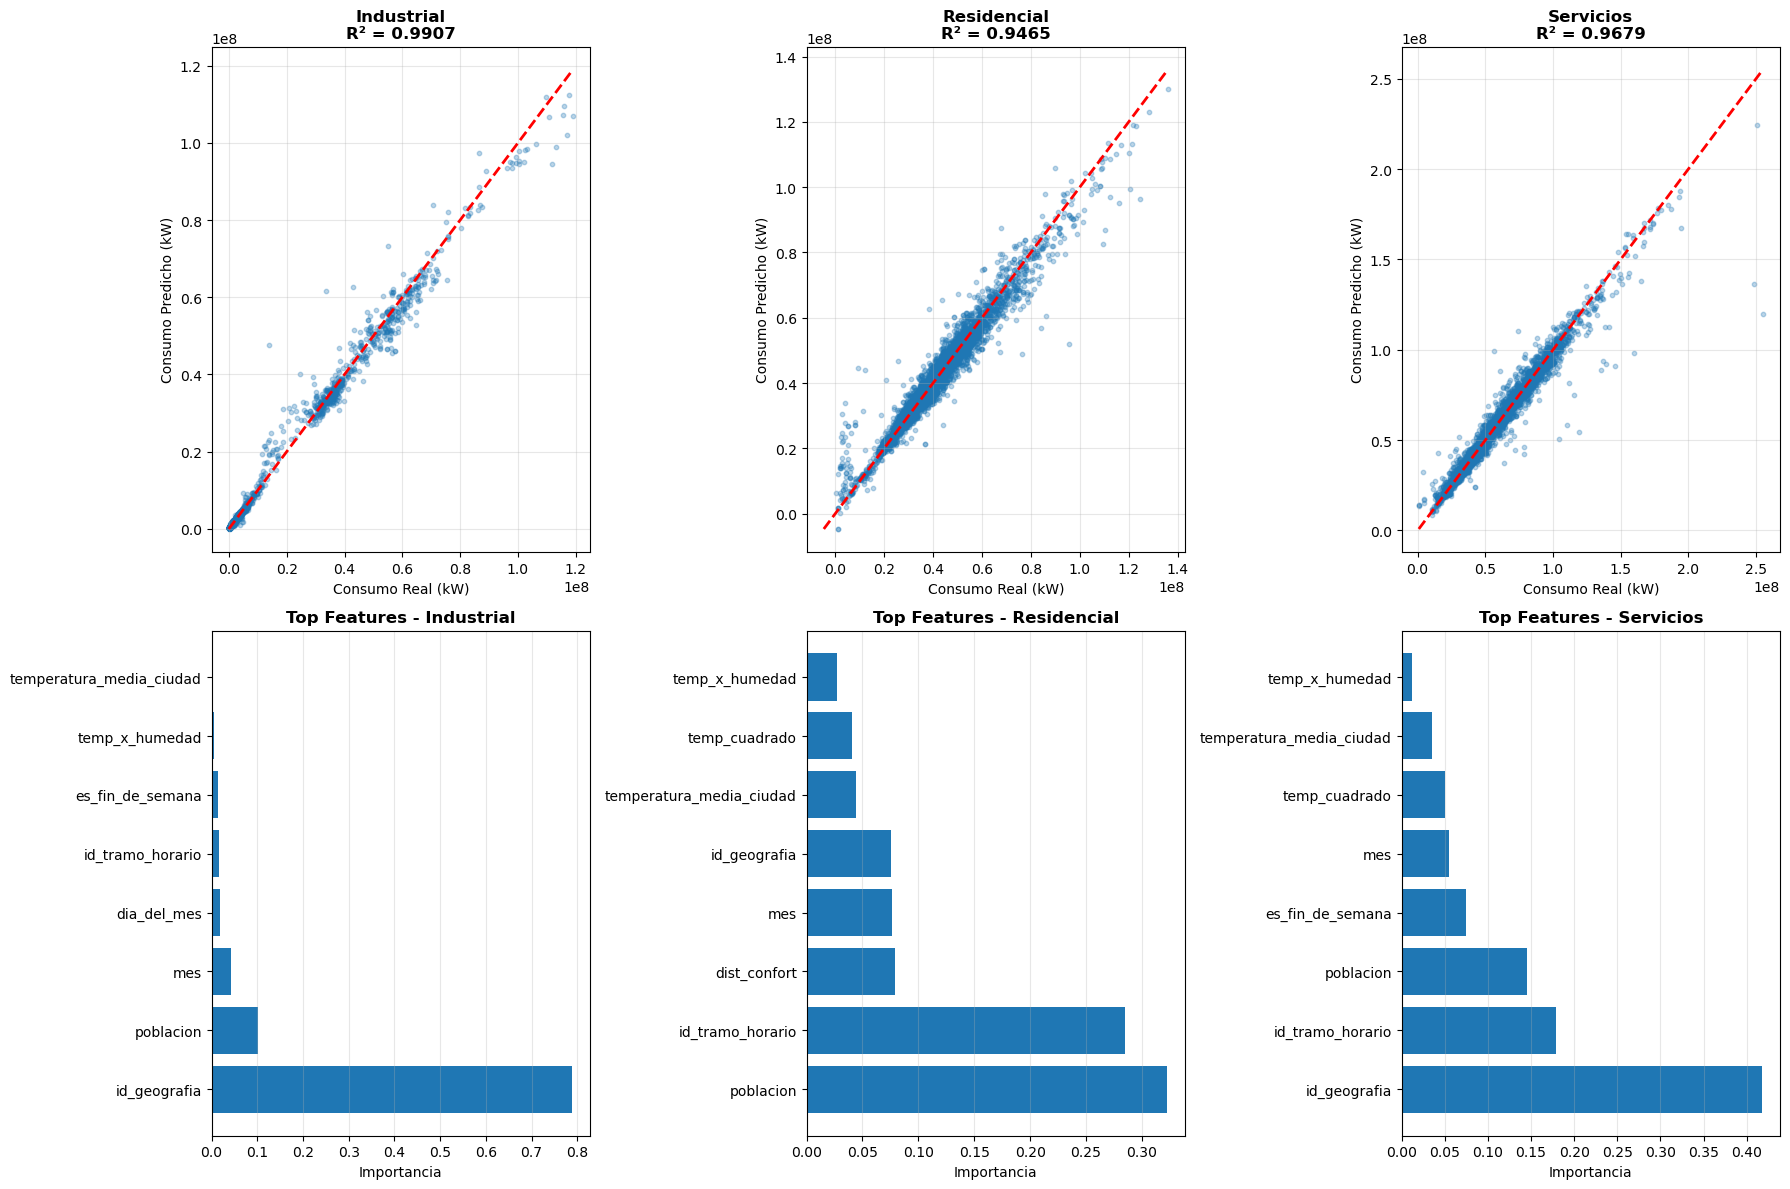

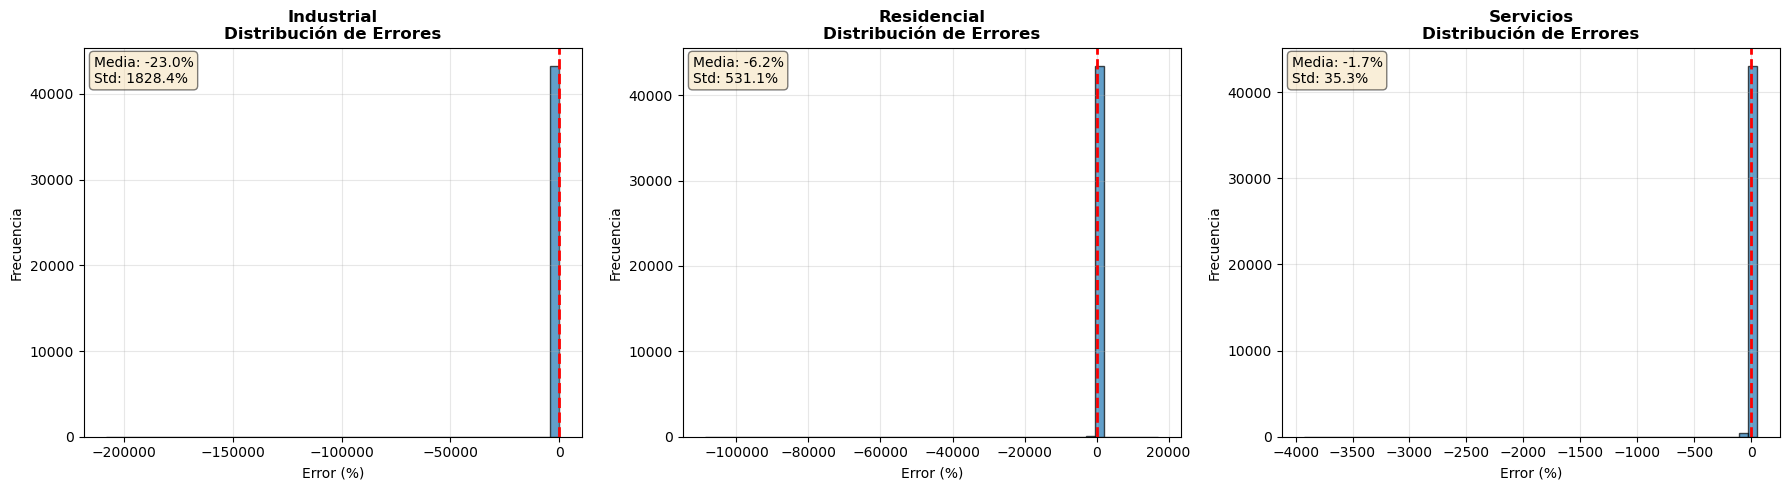

In [9]:
# ============================================================================
# PARTE 3: VISUALIZACIÓN DE RESULTADOS
# ============================================================================

print("\n" + "=" * 80)
print("📊 PARTE 3: VISUALIZACIÓN DE RESULTADOS")
print("=" * 80)

# Gráfico 1: Comparación de modelos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, sector in enumerate(['Industrial', 'Residencial', 'Servicios']):
    res = resultados_modelos[sector]
    
    # Fila 1: Real vs Predicho
    ax1 = axes[0, idx]
    
    # Sample para visualización
    if len(res['y_test']) > 5000:
        indices = np.random.choice(len(res['y_test']), 5000, replace=False)
        y_test_plot = res['y_test'].iloc[indices]
        y_pred_plot = res['y_pred'][indices]
    else:
        y_test_plot = res['y_test']
        y_pred_plot = res['y_pred']
    
    ax1.scatter(y_test_plot, y_pred_plot, alpha=0.3, s=10)
    
    # Línea diagonal perfecta
    min_val = min(y_test_plot.min(), y_pred_plot.min())
    max_val = max(y_test_plot.max(), y_pred_plot.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    ax1.set_xlabel('Consumo Real (kW)')
    ax1.set_ylabel('Consumo Predicho (kW)')
    ax1.set_title(f'{sector}\nR² = {res["r2"]:.4f}', fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Fila 2: Importancia de features
    ax2 = axes[1, idx]
    top_features = res['importancias'].head(8)
    ax2.barh(range(len(top_features)), top_features['Importancia'].values)
    ax2.set_yticks(range(len(top_features)))
    ax2.set_yticklabels(top_features['Feature'].values)
    ax2.set_xlabel('Importancia')
    ax2.set_title(f'Top Features - {sector}', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico 2: Distribución de errores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, sector in enumerate(['Industrial', 'Residencial', 'Servicios']):
    ax = axes[idx]
    res = resultados_modelos[sector]
    
    errores = res['y_test'].values - res['y_pred']
    error_pct = (errores / res['y_test'].values) * 100
    
    ax.hist(error_pct, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Error (%)')
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'{sector}\nDistribución de Errores', fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Añadir estadísticas
    media_error = error_pct.mean()
    std_error = error_pct.std()
    ax.text(0.02, 0.98, f'Media: {media_error:.1f}%\nStd: {std_error:.1f}%',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


In [10]:
# ============================================================================
# PARTE 4: RESUMEN Y RECOMENDACIONES
# ============================================================================

print("\n" + "=" * 80)
print("📋 PARTE 4: RESUMEN EJECUTIVO")
print("=" * 80)

resumen = pd.DataFrame([
    {
        'Sector': sector,
        'Modelo': res['nombre'],
        'R²': f"{res['r2']:.4f}",
        'MAE (kW)': f"{res['mae']:,.0f}",
        'Top Feature': res['importancias'].iloc[0]['Feature'],
        'Importancia': f"{res['importancias'].iloc[0]['Importancia']:.3f}"
    }
    for sector, res in resultados_modelos.items()
])

print("\n🎯 RESUMEN DE MODELOS:")
print(resumen.to_string(index=False))

print("\n" + "=" * 80)
print("💡 RECOMENDACIONES PARA PREDICCIÓN DE DEMANDA")
print("=" * 80)

print("""
✅ HALLAZGOS CLAVE:

1. ID_GEOGRAFÍA es el factor DOMINANTE (51-93% importancia)
   → La ubicación es más importante que el clima
   → Diferentes zonas tienen patrones de consumo muy distintos

2. TEMPERATURA tiene rol SECUNDARIO pero relevante
   → Residencial: 14.7% (climatización importante)
   → Servicios: 9.2% (oficinas con AC)
   → Industrial: 1.4% (procesos industriales menos afectados)

3. HORARIO es importante en Residencial (29%) y Servicios (17%)
   → Patrones diarios de actividad

📈 ESTRATEGIA DE PREDICCIÓN RECOMENDADA:

A. CORTO PLAZO (1-7 días):
   • Usar temperatura + horario + día de la semana
   • Segmentar por código postal
   • Ajustar por sector económico

B. MEDIO PLAZO (1-3 meses):
   • Incorporar pronóstico de temperatura
   • Considerar estacionalidad mensual
   • Ajustar por festivos conocidos

C. LARGO PLAZO (>3 meses):
   • Tendencias históricas por zona
   • Crecimiento poblacional
   • Menos peso a temperatura específica

🎯 SIGUIENTE PASO:
   Crear función de predicción que tome:
   • Código postal
   • Fecha/hora futura
   • Pronóstico de temperatura
   • Sector económico
   → Retorne: Demanda esperada + intervalo de confianza
""")

print("\n" + "=" * 80)
print("✨ Análisis completado - Modelos listos para producción")
print("=" * 80)


📋 PARTE 4: RESUMEN EJECUTIVO

🎯 RESUMEN DE MODELOS:
     Sector            Modelo     R²  MAE (kW)  Top Feature Importancia
 Industrial Gradient Boosting 0.9907   466,093 id_geografia       0.788
Residencial Gradient Boosting 0.9465 2,344,623    poblacion       0.322
  Servicios Gradient Boosting 0.9679 2,715,836 id_geografia       0.418

💡 RECOMENDACIONES PARA PREDICCIÓN DE DEMANDA

✅ HALLAZGOS CLAVE:

1. ID_GEOGRAFÍA es el factor DOMINANTE (51-93% importancia)
   → La ubicación es más importante que el clima
   → Diferentes zonas tienen patrones de consumo muy distintos

2. TEMPERATURA tiene rol SECUNDARIO pero relevante
   → Residencial: 14.7% (climatización importante)
   → Servicios: 9.2% (oficinas con AC)
   → Industrial: 1.4% (procesos industriales menos afectados)

3. HORARIO es importante en Residencial (29%) y Servicios (17%)
   → Patrones diarios de actividad

📈 ESTRATEGIA DE PREDICCIÓN RECOMENDADA:

A. CORTO PLAZO (1-7 días):
   • Usar temperatura + horario + día de la sem